In [1]:
from py_experimenter.experimenter import PyExperimenter
import py_experimenter.utils
import zlib
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from utils_ import Analyzer
import pickle

In [2]:
datasets = py_experimenter.utils.get_keyfield_data(PyExperimenter(experiment_configuration_file_path="config/experiments-fullforests-classification.cfg").config)["openmlid"]
print(datasets)

2024-06-26 18:48:19,252  | py-experimenter - INFO     | Initialized and connected to database


['3', '6', '12', '14', '16', '18', '21', '22', '23', '24', '26', '28', '30', '31', '32', '33', '36', '38', '44', '46', '54', '57', '60', '61', '154', '179', '180', '181', '182', '183', '184', '185', '188', '204', '273', '293', '300', '351', '354', '357', '389', '390', '391', '392', '393', '395', '396', '398', '399', '401', '485', '554', '679', '715', '718', '720', '722', '723', '727', '728', '734', '735', '737', '740', '741', '743', '751', '752', '761', '772', '797', '799', '803', '806', '807', '813', '816', '819', '821', '822', '823', '833', '837', '843', '845', '846', '847', '849', '866', '871', '881', '897', '901', '903', '904', '910', '912', '913', '914', '917', '923', '930', '934', '953', '958', '959', '962', '966', '971', '976', '977', '978', '979', '980', '991', '993', '995', '1000', '1002', '1018', '1019', '1020', '1021', '1036', '1037', '1039', '1040', '1041', '1042', '1049', '1050', '1053', '1059', '1067', '1068', '1069', '1111', '1116', '1119', '1120', '1128', '1130', '1134'

In [3]:
datasets_with_analyzer_available = []
for openmlid in datasets:
    if os.path.exists(get_filename_analyzer(openmlid, 0)):
        datasets_with_analyzer_available.append(int(openmlid))
print(f"{len(datasets_with_analyzer_available)} datasets with analyzers: {datasets_with_analyzer_available}")

189 datasets with analyzers: [3, 12, 14, 16, 18, 21, 22, 23, 24, 28, 30, 31, 32, 33, 36, 38, 44, 46, 54, 57, 60, 61, 179, 181, 182, 185, 188, 273, 357, 391, 392, 393, 396, 401, 679, 715, 718, 720, 722, 723, 727, 728, 734, 735, 737, 740, 741, 743, 751, 761, 772, 797, 799, 803, 806, 807, 813, 816, 819, 821, 822, 823, 833, 837, 843, 845, 846, 847, 849, 866, 871, 881, 897, 901, 903, 904, 910, 912, 913, 914, 917, 923, 930, 934, 953, 958, 959, 962, 966, 971, 976, 977, 978, 979, 980, 991, 993, 995, 1000, 1002, 1018, 1019, 1020, 1021, 1036, 1037, 1039, 1040, 1041, 1042, 1049, 1050, 1053, 1059, 1067, 1068, 1069, 1111, 1116, 1119, 1120, 1128, 1130, 1134, 1138, 1142, 1146, 1161, 1166, 1242, 1461, 1464, 1468, 1475, 1485, 1486, 1487, 1489, 1494, 1501, 1590, 4134, 4135, 4136, 4534, 4538, 4541, 23380, 23512, 23517, 40497, 40498, 40668, 40670, 40685, 40691, 40701, 40900, 40926, 40971, 40975, 40978, 40981, 40982, 40983, 40984, 41026, 41027, 41064, 41066, 41138, 41142, 41143, 41144, 41145, 41146, 41150,

dict_keys(['num_trees', 'variances_of_zt'])


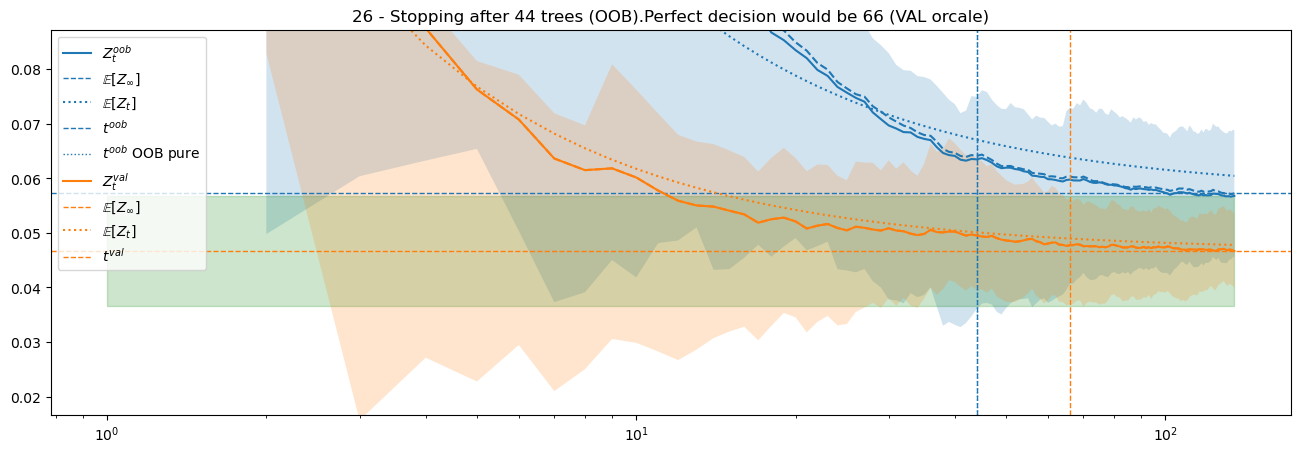

In [3]:
for openmlid in [26]:
    analyzer = Analyzer.for_dataset(openmlid, seed=0)
    #print(analyzer.confidence_term_for_correction_term_per_time["oob"][-1])
    analyzer.create_full_belief_plot()

In [11]:
def simulate_algorithm(analyzer, profiles, min_members=4):
    
    n, k = analyzer.Y_val.shape
    
    t, c, v = 0, 0, 0
    
    beta = 0.6
    
    eps = np.array([p[0] for p in profiles])
    
    def get_anticipated_gap(t):
        if t < min_members:
            return np.inf
        
        gaps = []
        for _, alpha in profiles:
            kappa = stats.norm.ppf(1 - beta * (1-alpha))
            tau = stats.t.ppf(1 - (1 - beta) * (1 - alpha) / k, df=t-1)
            gaps.append(kappa * np.sqrt(2 / (n*t)) + (v + tau * c / np.sqrt(t)) / t)
        return np.array(gaps)
    
    sizes = []
    while np.any(get_anticipated_gap(t) > eps):
        for tp in range(10**4):
            if np.all(get_anticipated_gap(t + tp) < eps):
                break
        
        t += tp
        sizes.append(t)
        v = analyzer.correction_terms_for_t1_per_time["oob"][t-1]
        c = analyzer.confidence_term_for_correction_term_per_time["oob"][t-1]
    return sizes

eps = 0.01
profile_list = [
    [(2 * eps, 0.999), (eps, 0.5)],
    [(2 * eps, 0.999), (eps, 0.7)],
    [(2 * eps, 0.99), (eps, 0.5)],
    [(1.5 * eps, 0.95), (eps, 0.7)],
    [(eps, 0.9)],
    [(eps, 0.99)],
    [(eps, 0.5)]
]

num_trees = []
gaps = []
for profiles in tqdm(profile_list):
    num_trees_for_profile = []
    gaps_for_profile = []
    for openmlid in datasets_with_analyzer_available:
        analyzer = get_analyzer_from_disk(openmlid, 0)
        sizes = simulate_algorithm(analyzer, profiles)
        t = sizes[-1]
        max_gap_after_t = np.round(np.abs((analyzer.scores_of_forests["val"][t:] - analyzer.scores_of_forests["val"][-1])).max(), 3)
        #if max_gap_after_t > eps:
         #   print(openmlid, t, max_gap_after_t, max_gap_after_t <= eps)
        num_trees_for_profile.append(t)
        gaps_for_profile.append(max_gap_after_t)
    num_trees.append(num_trees_for_profile)
    gaps.append(gaps_for_profile)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:15<00:00, 19.40s/it]


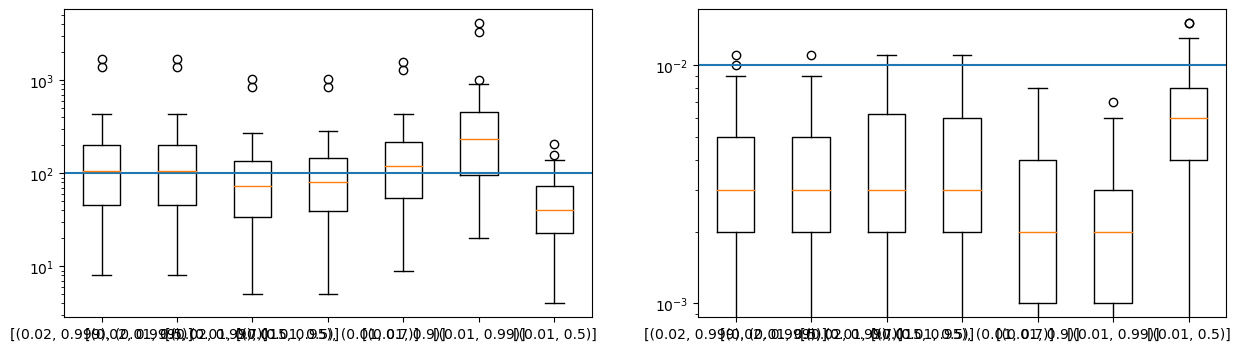

In [95]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

ax = axs[0]
ax.boxplot(num_trees)
ax.axhline(100)
ax.set_xticklabels(profile_list)
ax.set_yscale("log")

ax = axs[1]
ax.boxplot(gaps)
ax.axhline(0.01)
ax.set_xticklabels(profile_list)
ax.set_yscale("log")

In [4]:
eps_base = 0.01
df_results = get_results(
    datasets_with_analyzer_available,
    get_analyzer_from_disk,
    eps=eps_base,
    pareto_profiles=None,
    n_jobs=8,
    show_progress=True
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:55<00:00,  3.42it/s]


In [5]:
df_results

,openmlid,val_gap_100,ok_100,time_100,t_0.1,gap_oob_0.1,gap_val_0.1,ok_0.1,time_asrf_0.1,t_0.2,...,t_0.95,gap_oob_0.95,gap_val_0.95,ok_0.95,time_asrf_0.95,t_0.99,gap_oob_0.99,gap_val_0.99,ok_0.99,time_asrf_0.99
0,3,0.001407,True,5.420937,2,0.304709,0.040606,False,0.111474,2,...,60,0.004520,0.001940,True,3.308854,86,0.003590,0.001557,True,4.747068
1,12,0.003097,True,7.695423,42,0.017998,0.004333,True,3.286095,46,...,124,0.004090,0.002311,True,8.790564,167,0.004308,0.000004,True,10.524590
2,14,0.008953,True,8.325897,69,0.019272,0.006933,True,5.805028,74,...,163,0.005174,0.005232,True,11.015491,209,0.004739,0.003576,True,12.914703
3,16,0.002298,True,8.847395,74,0.018141,0.007561,True,6.628029,79,...,170,0.007920,0.002518,True,11.827742,218,0.004851,0.001177,True,13.795946
4,18,0.002082,True,5.836824,40,0.022850,0.005435,True,2.366053,43,...,117,0.009124,0.000541,True,6.378524,159,0.006372,0.002762,True,7.525456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,41165,0.008049,True,169.004214,114,0.018510,0.006456,True,190.237427,117,...,167,0.012652,0.004486,True,239.070503,188,0.011365,0.003585,True,258.436293
185,41168,0.004971,True,214.042281,55,0.023165,0.007516,True,168.053653,56,...,72,0.017793,0.005960,True,186.003942,78,0.016658,0.005897,True,192.336423
186,41946,0.000936,True,4.815632,2,0.270712,0.023070,False,0.098897,2,...,42,0.005986,0.002399,True,2.058793,63,0.002593,0.001874,True,3.088515
187,42733,0.005856,True,32.257456,2,0.336818,0.086627,False,3.571363,30,...,48,0.014682,0.010470,False,24.140955,55,0.012666,0.008981,True,25.302326


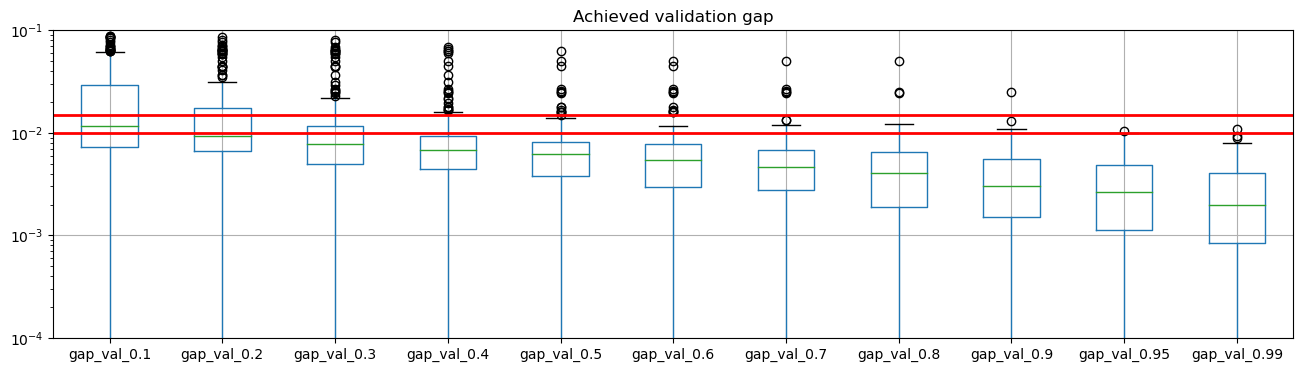

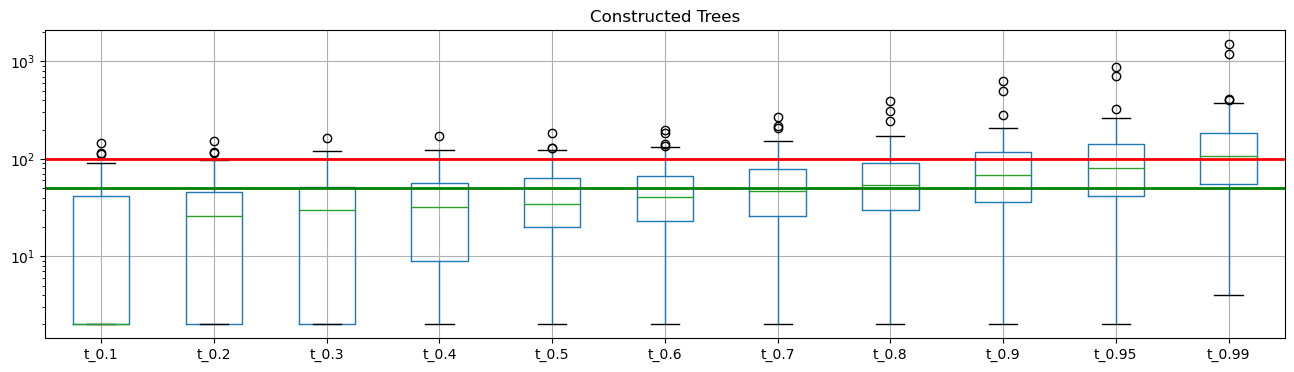

In [6]:
fig, ax = plt.subplots(figsize=(16, 4))
df_results[[c for c in df_results.columns if "gap_val" in c and "100" not in c]].boxplot(ax=ax)
ax.axhline(eps_base, linestyle="-", color="red", linewidth=2)
ax.axhline(1.5 * eps_base, linestyle="-", color="red", linewidth=2)
ax.set_title("Achieved validation gap")
ax.set_ylim([10**-4, 10**-1])
ax.set_yscale("log")
plt.show()

fig, ax = plt.subplots(figsize=(16, 4))
df_results[[c for c in df_results.columns if "t_" in c]].boxplot(ax=ax)
ax.axhline(100, linestyle="-", color="red", linewidth=2)
ax.axhline(50, linestyle="-", color="green", linewidth=2)
ax.set_yscale("log")
ax.set_title("Constructed Trees")
plt.show()

In [10]:
for openmlid in datasets_with_analyzer_available:
    analyzer = get_analyzer_from_disk(openmlid, 0)
    stopping_point = get_stopping_point(analyzer, profiles=profiles, mode="realistic", min_trees=2)
    
    if False:
        fig, ax = plt.subplots()
        for i, forest_size in enumerate([stopping_point, 50, 100]):
            l = get_certainty_profile_for_forest_size(analyzer, forest_size)
            ax.step([e[0] for e in l], [e[1] for e in l], label=forest_size)
            if i == 0:
                for alpha in [0.99, 0.9, 0.75]:
                    index = [e[0] for e in l].index(alpha)
                    ax.axhline(l[index][1], linestyle="dotted") # eps

        ax.axhline(eps_base, linestyle="--", color="black")
        ax.axvline(0.95, linestyle="--", color="black", linewidth=1)
        ax.set_title(f"Uncertainty trade-offs for different forest sizes on {openmlid}. Stopped at {stopping_point} trees")
        ax.set_xlabel("$\\alpha$")
        ax.set_ylabel("$\\varepsilon$")
        ax.legend()
        plt.show()

NameError: name 'profiles' is not defined

/tmp/ipykernel_32742/1737498539.py:45: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axvline(0, color="black", linewidth=1)
/tmp/ipykernel_32742/1737498539.py:46: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(0, color="black", linewidth=1)
/tmp/ipykernel_32742/1737498539.py:50: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(-1, color="green", linestyle="--", alpha=0.4)
/tmp/ipykernel_32742/1737498539.py:51: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(0, color="gray", linestyle="--", alpha=0.4)
/tmp/ipykernel_32742/1737498539.py:52: UserWarning: All values for SymLogScale a

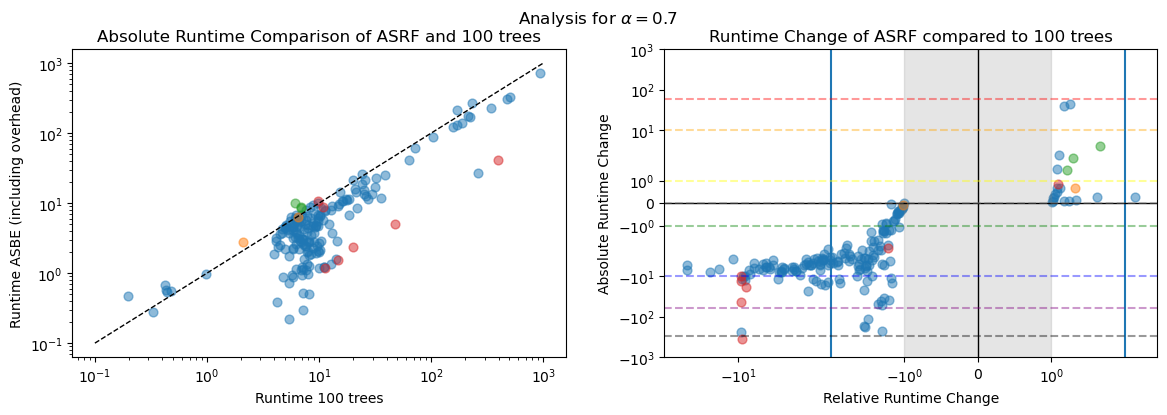

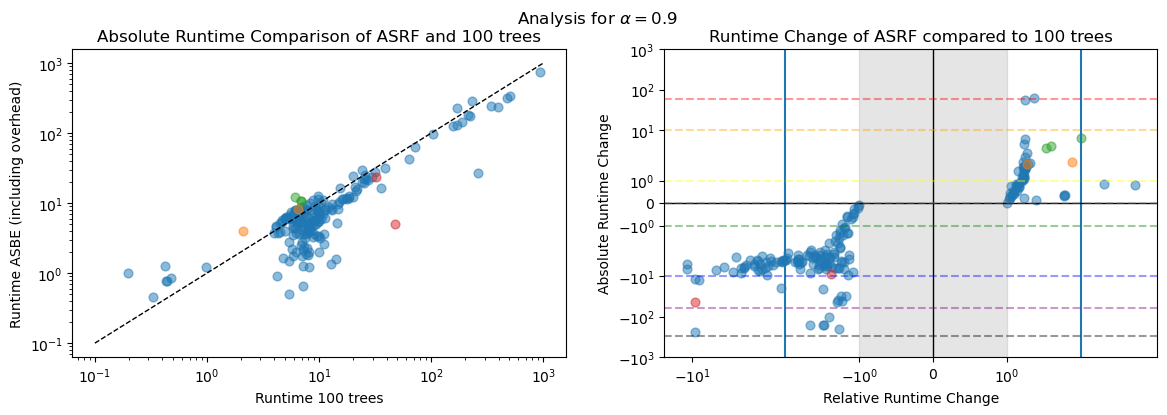

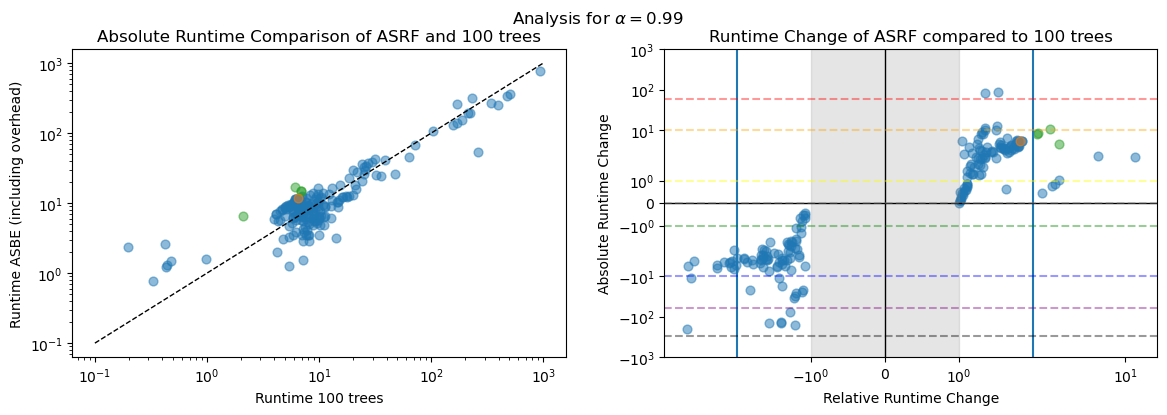

In [9]:
alphas = [0.7, 0.9, 0.99]
runtimes_asrf = df_results[[f"time_asrf_{alpha}" for alpha in alphas]].values
runtimes_baseline = df_results["time_100"].values

for idx, alpha in enumerate(alphas):

    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    fig.suptitle(f"Analysis for $\\alpha = {alpha}$")

    ax = axs[0]
    mask_we = df_results[f"gap_val_{alpha}"] < eps_base
    mask_100 = df_results[f"val_gap_100"] < eps_base

    masks = [mask_100 & mask_we, ~mask_100 & mask_we, mask_100 & ~mask_we, ~mask_100 & ~mask_we]
    colors = ["C0", "C2", "C3", "C1"]
    point_size=40
    point_alpha=0.5

    for mask, color in zip(masks, colors):
        ax.scatter(runtimes_baseline[mask], runtimes_asrf[mask,idx], s=point_size, color=color, alpha=point_alpha)
    ax.plot([0.1, 10**3], [0.1, 10**3], linestyle="--", color="black", linewidth=1)
    ax.set_title("Absolute Runtime Comparison of ASRF and 100 trees")
    ax.set_xlabel("Runtime 100 trees")
    ax.set_ylabel("Runtime ASBE (including overhead)")
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax = axs[1]
    y_vals = runtimes_asrf[:,idx] - runtimes_baseline
    x_vals = runtimes_asrf[:,idx] / runtimes_baseline
    mask = x_vals < 1
    x_vals[mask] = -1 / x_vals[mask]

    for mask, color in zip(masks, colors):
        ax.scatter(x_vals[mask], y_vals[mask], s=point_size, color=color, alpha=point_alpha)
    ax.set_title("Runtime Change of ASRF compared to 100 trees")
    ax.set_xlabel("Relative Runtime Change")
    ax.set_ylabel("Absolute Runtime Change")
    ax.set_xscale("symlog")
    ax.set_yscale("symlog")
    ax.axvline(-2)
    ax.axvline(2)
    ax.set_ylim([-10**3, 10**3])

    ax.axvline(0, color="black", linewidth=1)
    ax.axhline(0, color="black", linewidth=1)
    ax.axhline(-300, color="black", linestyle="--", alpha=0.4)
    ax.axhline(-60, color="purple", linestyle="--", alpha=0.4)
    ax.axhline(-10, color="blue", linestyle="--", alpha=0.4)
    ax.axhline(-1, color="green", linestyle="--", alpha=0.4)
    ax.axhline(0, color="gray", linestyle="--", alpha=0.4)
    ax.axhline(1, color="yellow", linestyle="--", alpha=0.4)
    ax.axhline(10, color="orange", linestyle="--", alpha=0.4)
    ax.axhline(60, color="red", linestyle="--", alpha=0.4)
    ax.fill_between([-1, 1], [-10**3, -10**3], [10**3, 10**3], color="gray", alpha=0.2)

    plt.show()

In [ ]:
%%time
import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection
X, y = sklearn.datasets.load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=10**4).fit(X_train, y_train)

In [ ]:
probs_by_tree = np.array([tree.predict_proba(X_test) for tree in tqdm(rf.estimators_)])
Y_test = sklearn.preprocessing.OneHotEncoder(sparse_output=False).fit_transform(np.array([y_test]).T)

# Check Prediction Error on v When CI is Small

In [ ]:
vals = []
for openmlid in datasets_with_analyzer_available:
    analyzer = get_analyzer_from_disk(openmlid, 0)
    correction_terms_over_time = np.array(analyzer.correction_terms_for_t1_per_time["oob"])
    true_v = correction_terms_over_time[-1]
    
    # get timestep in which the CI is small
    for t in range(10, len(analyzer.scores_of_single_trees["oob"]) + 1):
        uncertainty = np.std(analyzer.scores_of_single_trees["oob"][:t]) / np.sqrt(t)
        if uncertainty < 0.01:
            break
    
    vals.append(np.round(np.abs(true_v - correction_terms_over_time[t - 1]) / (t - 1), 4))

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(vals)
plt.show()

In [ ]:
def create_var_estimate_error_plot(
        analyzer,
        alpha,
        eps,
        ci_offset,
        min_trees=5,
        decision_oob=True,
        scoring_oob=True,
        eps_limit_multiplier=3,
        ax=None
):
    second_key = alpha


    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 5))
    else:
        fig = None
        
    variances_per_tree_size = pd.read_csv("../experiments/variances.csv").values[:,1]

    decision_lines = {}
    x_lim = 400
    for i, key in enumerate(["oob", "val"]):
        oob = key == "oob"
        color = f"C{i}"
        scores = analyzer.scores_of_forests[key]
        correction_terms_over_time = analyzer.correction_terms_for_t1_per_time[key]

        times = np.arange(1, len(scores) + 1)
        print(correction_terms_over_time[-1])
        
        ax.axvline(correction_terms_over_time[-1] / eps, color=color, linestyle="--", label="Accept zone")

        # check error in single point prediction
        estimate_of_v_t_base = (np.array(scores) - np.array(analyzer.single_tree_scores_mean_ests[key]) + correction_terms_over_time * (1 - 1 / times))
        estimate_of_v_t_uncertainty_term = np.array(analyzer.single_tree_scores_std_ests[key]) / np.sqrt(times * 0.366)
        uncertainty_coeff = 0
        estimate_of_v_t = np.max([np.abs(estimate_of_v_t_base + multiplier * estimate_of_v_t_uncertainty_term) for multiplier in [-uncertainty_coeff, uncertainty_coeff]], axis=0)**2
        
        pred_error = (variances_per_tree_size - estimate_of_v_t[:2000])
        
        ax.axhline(5*10**-6)
        ax.axhline(5*-10**-6)
        ax.plot(times[:2000], pred_error)
        ax.set_xscale("log")
        #ax.set_yscale("log")
        ax.set_ylim([-10**-5, 10**-5])

    if fig is not None:
        fig.savefig(f"plots/{openmlid}.pdf", bbox_inches="tight")
        plt.show()

for openmlid in [3]:#datasets_with_analyzer_available:
    analyzer = get_analyzer_from_disk(openmlid, 0)
    print(openmlid)
    
    create_var_estimate_error_plot(analyzer, alpha=0.7, eps=0.01, ci_offset=2)

In [ ]:
fig, ax = plt.subplots()
domain = np.arange(1, 200)
ax.plot(domain, eps - 0.1/domain)

In [ ]:
eps - 0.5/100

In [ ]:
10**-5/(eps**2)

In [ ]:
f = lambda eps, var_est, t, v: (var_est / (eps - v/t)**2)
eps = 0.01
var_est = 10**-6
t = 10**100
v = 0.2
if eps < v/t:
    raise ValueError()
f(eps, var_est, t, v)

#g = lambda eps, v_y, v_z, t, alpha: 2 * np.sqrt(v_z / t) + v/t
#g(eps, v_y=v, v_z=var_est, t=t, alpha=1)

In [ ]:
Y_test = sklearn.preprocessing.OneHotEncoder(sparse_output=False).fit_transform(np.array([y_test]).T)

In [ ]:
def plot_estimates_of_correction_term(self, axs=None):
    if axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(20, 4))
    else:
        fig = None

    times = np.arange(1, self.num_trees + 1)

    # correction term without t
    ax = axs[0]
    ax.plot(times, self.correction_terms_for_t1_per_time["oob"], label="$\\mathbb{V}_{oob}$")
    ax.plot(times, self.correction_terms_for_t1_per_time["val"], label="$\\mathbb{V}_{val}$")
    x_limit = 150
    for (key, oob), do_discount in it.product(zip(["oob", "val"], [True, False]), [True, False]):
        color = f"C{0 if oob else 1}"
        linestyle = "--" if do_discount else "dotted"
        num_tree_count_for_stable_correction_term_estimate = self.get_num_trees_required_for_stable_correction_term_estimate(
            oob=oob, do_discount=do_discount)
        ax.axvline(num_tree_count_for_stable_correction_term_estimate, linestyle=linestyle, color=color,
                   label="num trees for stable estimate of $\\mathbb{V}_{" + key + "}$ " + (
                       "" if do_discount else "not") + " discounting")
        x_limit = max([x_limit, num_tree_count_for_stable_correction_term_estimate + 10])

    #ax.set_xlim([1, x_limit])
    ax.set_xscale("log")

    # correction term with t
    ax = axs[1]
    ax.plot(times, self.correction_terms_for_t1_per_time["oob"] / times, label="$\\mathbb{V}_{oob}$")
    ax.plot(times, self.correction_terms_for_t1_per_time["val"] / times, label="$\\mathbb{V}_{val}$")
    x_limit = 150
    for (key, oob), do_discount in it.product(zip(["oob", "val"], [True, False]), [True, False]):
        color = f"C{0 if oob else 1}"
        linestyle = "--" if do_discount else "dotted"
        num_tree_count_for_stable_correction_term_estimate = self.get_num_trees_required_for_stable_correction_term_estimate(
            oob=oob, do_discount=do_discount)
        ax.axvline(num_tree_count_for_stable_correction_term_estimate, linestyle=linestyle, color=color,
                   label="num trees for stable estimate of $\\mathbb{V}_{" + key + "}$ " + (
                       "" if do_discount else "not") + " discounting")
        x_limit = max([x_limit, num_tree_count_for_stable_correction_term_estimate + 10])
    ax.set_xlim([1, x_limit])
    ax.set_xscale("log")

    if fig is not None:
        ax.legend()
        ax.set_title("Estimates of correction term $\\varphi(1)$ over time.")
        plt.show()

plot_estimates_of_correction_term(analyzer)

In [ ]:
from evalutils import *
X, y = get_dataset(12)

In [ ]:
%%time
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=10**4, n_jobs=8).fit(X_train, y_train)
Y_test = sklearn.preprocessing.OneHotEncoder(sparse_output=False).fit_transform(np.array([y_test]).T)

In [ ]:
probs_by_tree = np.array([tree.predict_proba(X_test) for tree in tqdm(rf.estimators_)])

In [ ]:
probs_by_tree[:180].var(axis=0).sum(axis=1).mean()

In [ ]:
t = rf.n_estimators
anchors = range(10, 1001, 50)
brier_score_means = []
brier_score_stds = []
brier_score_mins = []
brier_score_maxs = []

for a in tqdm(anchors):
    scores_at_a = []
    for i in range(10**2):
        permutation = probs_by_tree[np.random.choice(range(t), a, replace=False)]
        scores_at_a.append(np.round(((permutation.mean(axis=0) - Y_test)**2).sum(axis=1).mean(), 3))
    brier_score_means.append(np.mean(scores_at_a))
    brier_score_stds.append(np.std(scores_at_a))
    brier_score_mins.append(np.min(scores_at_a))
    brier_score_maxs.append(np.max(scores_at_a))
brier_score_means = np.array(brier_score_means)
brier_score_stds = np.array(brier_score_stds)
brier_score_mins = np.array(brier_score_mins)
brier_score_maxs = np.array(brier_score_maxs)

In [ ]:
fig, ax = plt.subplots()
ax.plot(anchors, brier_score_means)
ax.fill_between(anchors, brier_score_mins, brier_score_maxs, alpha=0.2)
plt.show()

In [ ]:
n = 10**5
k = 2
t = 10**2
alpha_intersect = 0.7
stats.norm.interval(alpha_intersect, loc=0, scale= k * 0.143 / np.sqrt(t))[1]

In [ ]:
def get_certainty_profile_for_forest_size(self, size, oob=True):
    key = "oob" if oob else "val"

    tree_scores = self.scores_of_single_trees[key][:size]
    std_of_scores = np.std(tree_scores)
    correction_term = self.correction_terms_for_t1_per_time[key][size - 1] / size#((0.336 if oob else 1)  * size)
    
    alphas = np.linspace(0.01, 0.99, 99).round(2)
    gaps = []
    for alpha in alphas:
        ci = stats.norm.interval(alpha, loc=0, scale=std_of_scores / np.sqrt((0.366 if oob else 1) * size))
        gaps.append(ci[1] + correction_term)
    return list(zip(alphas, gaps))

In [ ]:
runtimes_asrf = df_results[[c for c in df_results.columns if "time_asrf" in c]].values
runtimes_baseline = df_results["time_100"].values
fig, axs = plt.subplots(1, 2, figsize=(14, 3))
ax = axs[0]
ax.boxplot([row / runtimes_baseline for row in runtimes_asrf.T])
ax.set_xticklabels(alphas)
ax.axhline(0.8, color="blue", linestyle="--")
ax.axhline(1, color="green", linestyle="--")
ax.axhline(1.1, color="yellow", linestyle="--")
ax.axhline(1.25, color="orange", linestyle="--")
ax.axhline(1.5, color="red", linestyle="--")
ax.set_yscale("log")

ax = axs[1]
ax.boxplot([row - runtimes_baseline for row in runtimes_asrf.T])
ax.set_xticklabels(alphas)
ax.set_yscale("symlog")
ax.axhline(-10, color="blue", linestyle="--")
ax.axhline(-1, color="green", linestyle="--")
ax.axhline(0, color="gray", linestyle="--")
ax.axhline(1, color="orange", linestyle="--")
ax.axhline(10, color="red", linestyle="--")

plt.show()

# CREATE 3D plot with (#validation instances, #trees, gap)
We would expect the gap to drop very quickly for larger datasets, because the variance for both scores should be small (those for probabilities can still be large).

In [ ]:
np.nanmean(prob_history[:10], axis=0)

In [ ]:
fig, ax = plt.subplots()
forest_sizes = range(2, len(stop_estimates) + 2)
ax.plot(forest_sizes, stop_estimates)
#ax.set_ylim([380, 500])
margin = 10
limit = 200
ax.fill_between(forest_sizes, stop_estimates[-1] - margin, stop_estimates[-1] + margin, alpha=0.2)
ax.plot([10, limit], [10, limit], color="black", linestyle="--", linewidth=1)
ax.set_xlim([0, limit])
plt.show()

In [ ]:
prob_history = prob_history_val
Y = Y_test
brier_score_per_forest_size = [np.nanmean(((Y - np.nanmean(prob_history[:t], axis=0))**2).sum(axis=1)) for t in tqdm(range(1, 500))]
brier_score_per_forest_size

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(range(len(brier_score_per_forest_size)), brier_score_per_forest_size)
ax.set_ylim([0, 0.05])
plt.show()